In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import SGD

In [ ]:
org_df = pd.read_csv('crypto_data_news_reddit_final.csv',index_col=0)
org_df['flair'] = org_df['gnews_flair'] + org_df['reddit_flair']
org_df['tb_polarity'] = org_df['gnews_tb_polarity'] + org_df['reddit_tb_polarity']
org_df['tb_subjectivity'] = org_df['gnews_tb_subjectivity'] + org_df['reddit_tb_subjectivity']
org_df['sid_pos'] = org_df['gnews_sid_pos'] + org_df['reddit_sid_pos']
org_df['sid_neg'] = org_df['gnews_sid_neg'] + org_df['reddit_sid_neg']
org_df = org_df[['open_BTCUSDT','high_BTCUSDT','low_BTCUSDT', 'close_BTCUSDT', 'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'flair', 'tb_polarity', 'tb_subjectivity', 'sid_pos', 'sid_neg']]

dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
num_of_features = len(org_df.columns)
expr_name = 'experimentfinal'
look_back = 24*120 # 120 days, as each entry is for 1 hour
lstm_layers = 64
epochs=40
batch_size=128
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('close_BTCUSDT')

def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)

train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))


model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
from keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer)





In [ ]:
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/40
57/57 [==============================] - 19s 149ms/step - loss: 0.0391 - val_loss: 0.0275
Epoch 2/40
57/57 [==============================] - 7s 132ms/step - loss: 0.0017 - val_loss: 0.0132
Epoch 3/40
57/57 [==============================] - 7s 117ms/step - loss: 4.6661e-04 - val_loss: 0.0082
Epoch 4/40
57/57 [==============================] - 8s 133ms/step - loss: 2.8450e-04 - val_loss: 0.0062
Epoch 5/40
57/57 [==============================] - 7s 117ms/step - loss: 2.5369e-04 - val_loss: 0.0050
Epoch 6/40
57/57 [==============================] - 8s 132ms/step - loss: 2.3843e-04 - val_loss: 0.0041
Epoch 7/40
57/57 [==============================] - 7s 118ms/step - loss: 2.2623e-04 - val_loss: 0.0034
Epoch 8/40
57/57 [==============================] - 7s 132ms/step - loss: 2.1338e-04 - val_loss: 0.0028
Epoch 9/40
57/57 [==============================] - 7s 117ms/step - loss: 1.9715e-04 - val_loss: 0.0023
Epoch 10/40
57/57 [==============================] - 8s 134ms/step - lo

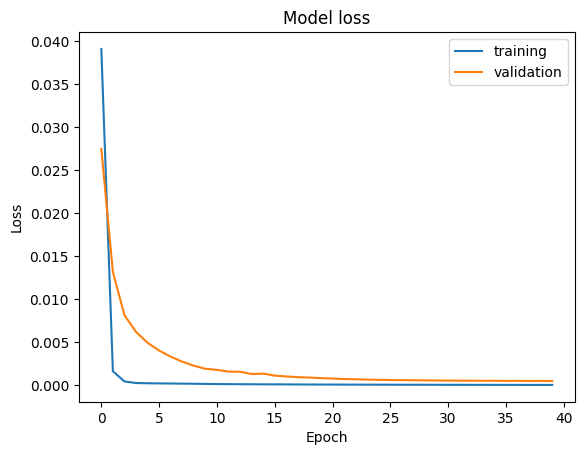

In [ ]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col]

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]
# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))
# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

14/14 [==============================] - 0s 34ms/step


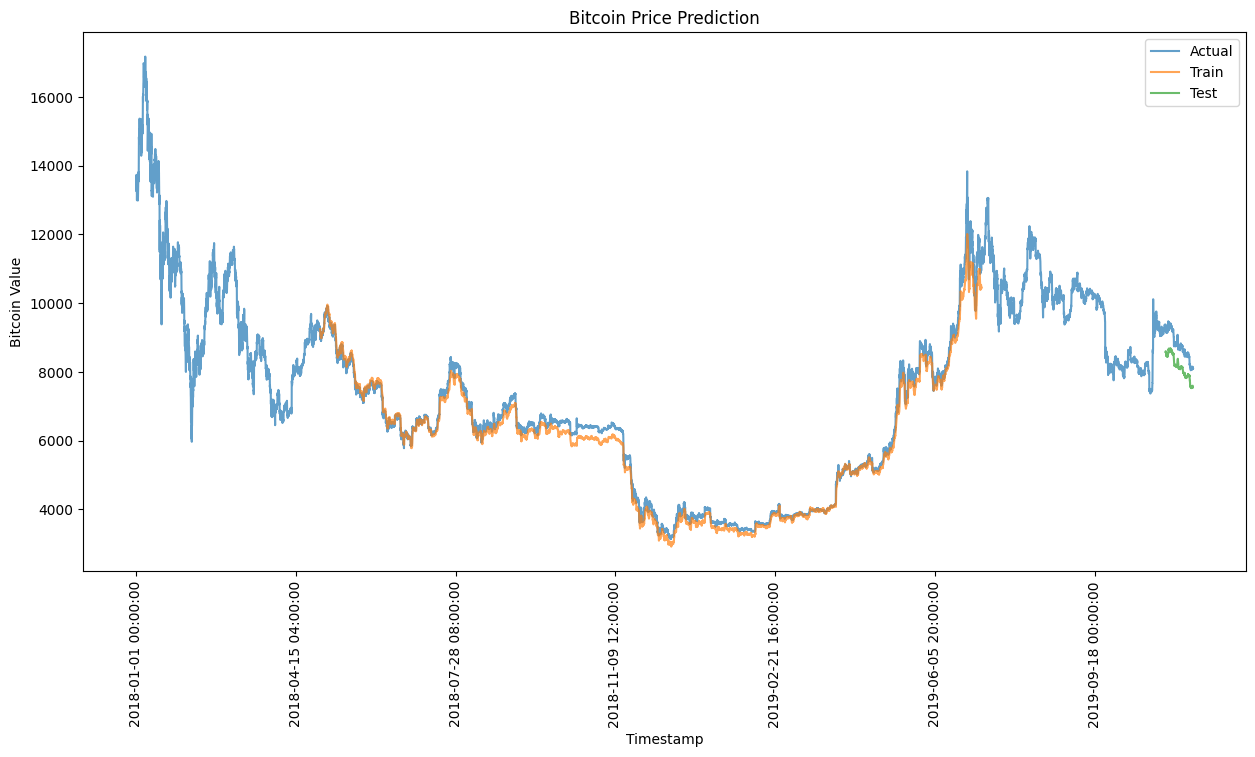

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict
# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp',inplace=True)
# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [ ]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_4
--------------------------------------------------
look_back days: 120.0
lstm_layers: 64
epochs: 40
batch_size: 128
dataset features ['open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT', 'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'flair', 'tb_polarity', 'tb_subjectivity', 'sid_pos', 'sid_neg']
--------------------------------------------------
Train Score: 244.16 RMSE
Test Score: 635.36 RMSE
--------------------------------------------------
Train Score: 184.18 MAE
Test Score: 630.51 MAE
--------------------------------------------------
Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (